Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)

import shap


Config

In [2]:

RANDOM_STATE = 42
DATA_PATH = "Healthcare-Diabetes_cleaned.csv"

Load dataset

In [3]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

print("\nMissing values:")
display(df.isna().sum())

print("\nOutcome distribution:")
display(df["Outcome"].value_counts())
display(df["Outcome"].value_counts(normalize=True))

Shape: (1427, 10)
Columns: ['Id', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,1,89,66,23,94,28.1,0.167,21,0
1,95,2,142,82,18,64,24.7,0.761,21,0
2,106,1,126,56,29,152,28.7,0.801,21,0
3,120,4,99,76,15,51,23.2,0.223,21,0
4,137,0,100,70,26,50,30.8,0.597,21,0



Missing values:


Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Outcome distribution:


Outcome
0    960
1    467
Name: count, dtype: int64

Outcome
0    0.67274
1    0.32726
Name: proportion, dtype: float64

Drop ID + define X and y

In [4]:
df = df.drop(columns=["Id"])

X = df.drop(columns=["Outcome"])
y = df["Outcome"].astype(int)

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))

X shape: (1427, 8)
y distribution:
 Outcome
0    0.67274
1    0.32726
Name: proportion, dtype: float64


Train-test split 80:20

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (1141, 8)
Test : (286, 8)


Scaling

In [6]:
# For Logistic Regression
scaled_preprocess = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# For tree-based
tree_preprocess = "passthrough"

Cross-validation setup

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "auc": "roc_auc",
    "f1": "f1",
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall"
}

Evaluation metrics + plot

In [8]:
cv_rows = []
test_rows = []
models_fitted = {}

def run_model(name, model):
    # --- CV on Train 80% ---
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n=== {name} | 5-Fold CV (Train 80%) ===")
    for k in ["accuracy", "precision", "recall", "f1", "auc"]:
        print(f"{k:<9}: {scores[f'test_{k}'].mean():.4f} ± {scores[f'test_{k}'].std():.4f}")

    cv_rows.append({
        "Model": name,
        "accuracy_mean": scores["test_accuracy"].mean(),
        "precision_mean": scores["test_precision"].mean(),
        "recall_mean": scores["test_recall"].mean(),
        "f1_mean": scores["test_f1"].mean(),
        "auc_mean": scores["test_auc"].mean(),
    })

    # --- Fit on full Train, evaluate on Test 20% ---
    model.fit(X_train, y_train)
    models_fitted[name] = model

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc_test = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {name} | Test Set (20%) ===")
    print(f"AUC: {auc_test}")
    print(classification_report(y_test, y_pred, digits=4))

    test_rows.append({
        "Model": name,
        "AUC": auc_test,
        "F1": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    })

    # --- Plots (per model) ---
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve - {name}")
        plt.show()

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


### Logistic Regression


=== Logistic Regression | 5-Fold CV (Train 80%) ===
accuracy : 0.7836 ± 0.0275
precision: 0.7089 ± 0.0497
recall   : 0.5766 ± 0.0680
f1       : 0.6340 ± 0.0508
auc      : 0.8458 ± 0.0301

=== Logistic Regression | Test Set (20%) ===
AUC: 0.8801529255319149
              precision    recall  f1-score   support

           0     0.8429    0.9219    0.8806       192
           1     0.8026    0.6489    0.7176        94

    accuracy                         0.8322       286
   macro avg     0.8227    0.7854    0.7991       286
weighted avg     0.8296    0.8322    0.8270       286



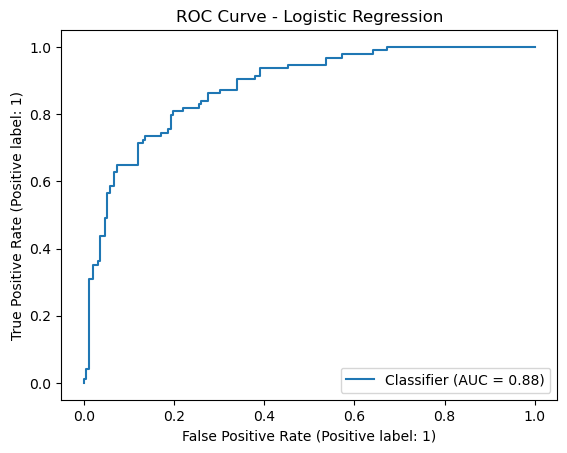

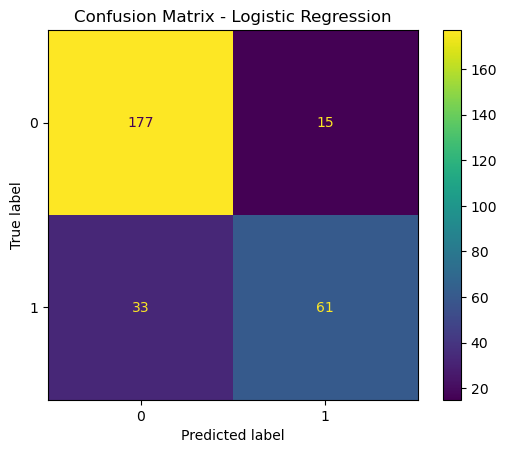

In [9]:
run_model(
    "Logistic Regression",
    Pipeline([
        ("prep", scaled_preprocess),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ])
)


### Random Forest


=== Random Forest | 5-Fold CV (Train 80%) ===
accuracy : 0.9851 ± 0.0102
precision: 0.9790 ± 0.0238
recall   : 0.9759 ± 0.0100
f1       : 0.9774 ± 0.0153
auc      : 0.9976 ± 0.0030

=== Random Forest | Test Set (20%) ===
AUC: 0.9995567375886525
              precision    recall  f1-score   support

           0     0.9948    1.0000    0.9974       192
           1     1.0000    0.9894    0.9947        94

    accuracy                         0.9965       286
   macro avg     0.9974    0.9947    0.9960       286
weighted avg     0.9965    0.9965    0.9965       286



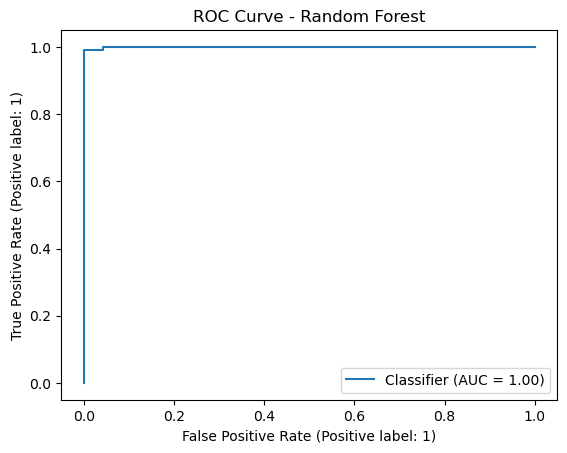

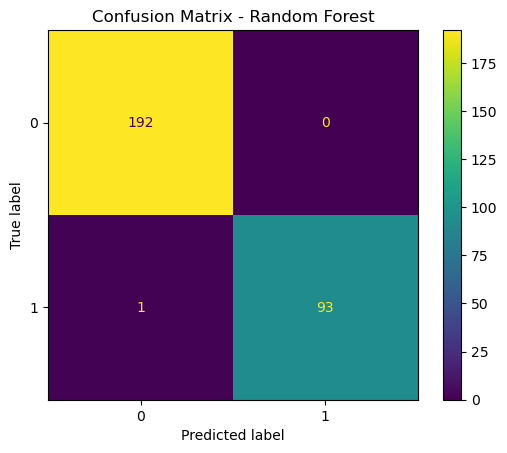

In [10]:
run_model(
    "Random Forest",
    Pipeline([
        ("prep", tree_preprocess),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
    ])
)

In [11]:
test_df = pd.DataFrame(test_rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)

display(test_df.round(6))

,Model,AUC,F1,Accuracy,Precision,Recall
0,Random Forest,0.999557,0.994652,0.996503,1.000000,0.989362
1,Logistic Regression,0.880153,0.717647,0.832168,0.802632,0.648936


Store best model (random forest)

In [12]:
best_name = "Random Forest"
best_model = models_fitted[best_name]

print("Best model (fixed):", best_name)

Best model (fixed): Random Forest


SHAP explainability

Explanation shape: (286, 8)


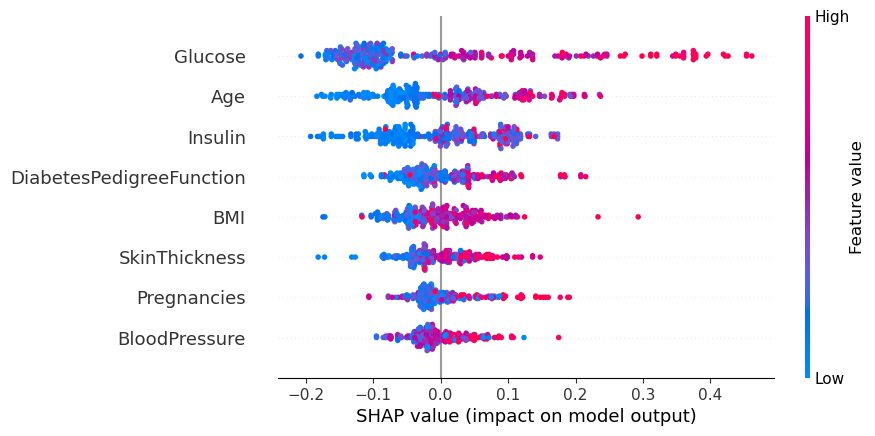

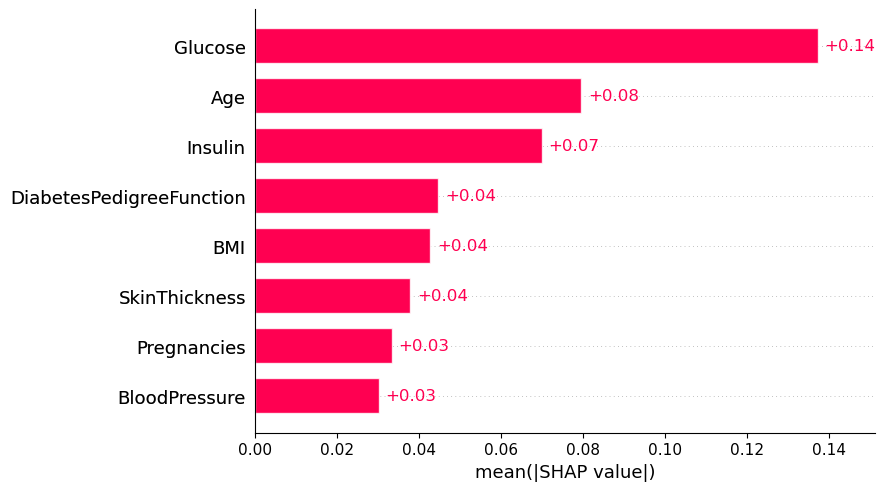

In [13]:
import shap
import numpy as np
import pandas as pd

prep = best_model.named_steps["prep"]
clf  = best_model.named_steps["clf"]

feature_names = X.columns.tolist()

# Prepare data
X_test_proc = prep.transform(X_test) if prep != "passthrough" else X_test.values
X_test_proc_df = pd.DataFrame(X_test_proc, columns=feature_names)

# Explainer
explainer = shap.TreeExplainer(clf)

# Explanation object (may contain outputs for both classes)
explanation = explainer(X_test_proc_df)

# Select class 1 (diabetes)
if hasattr(explanation, "values") and np.array(explanation.values).ndim == 3:
    explanation_1 = shap.Explanation(
        values=explanation.values[:, :, 1],
        base_values=explanation.base_values[:, 1] if np.array(explanation.base_values).ndim == 2 else explanation.base_values,
        data=explanation.data,
        feature_names=explanation.feature_names
    )
else:
    explanation_1 = explanation

print("Explanation shape:", np.array(explanation_1.values).shape)

# Beeswarm (ALL features)
shap.plots.beeswarm(explanation_1, max_display=len(feature_names))

# Bar (ALL features)
shap.plots.bar(explanation_1, max_display=len(feature_names))
